In [2]:
import rebound
import reboundx
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
try:
    plt.style.use('paper')
except:
    pass

In [3]:
def makesim(eps_J2=None, e=1.e-2, dtfac=0.01, integrator="whfast"):
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.add(m=1.)
    sim.add(m=1.e-8, a=1., e=e)
    sim.add(m=1.e-8, a=2., e=e)
    sim.move_to_com()
    sim.integrator=integrator

    sim.dt = dtfac*sim.particles[1].P

    if eps_J2:
        rebx = reboundx.Extras(sim)
        gh = rebx.load_force("gravitational_harmonics")
        rebx.add_force(gh)
        ps = sim.particles
        ps[0].params['R_eq'] = ps[1].a
        ps[0].params['J2'] = 2*eps_J2 # eps = 1/2 J2 (r/a)**2
    try:
        return sim, rebx, gh
    except:
        return sim

In [4]:
def run(eps_J2=None, e=1.e-2, dtfac=0.01, tmax=1.e3, integrator="whfast", get_e=False):
    Nout = 1000
    times = np.logspace(0, np.log10(tmax), Nout)

    sim, rebx, gh = makesim(eps_J2=eps_J2, e=e, dtfac=dtfac, integrator=integrator)
    E0 = sim.calculate_energy() + rebx.gravitational_harmonics_hamiltonian()
    Es, es = np.zeros(Nout), np.zeros(Nout)
    for i, time in enumerate(times):
        sim.integrate(time)
        E = sim.calculate_energy() + rebx.gravitational_harmonics_hamiltonian()
        Es[i] = np.abs((E-E0)/E0)
        es[i] = sim.particles[1].e
    if get_e:
        return Es, es
    else:
        return Es

In [38]:
%%time

tmax = 1.e4
e=1.e-2
eps_J2 = 1.e-3
dtfac = 1.e-2
EsWH = run(eps_J2=eps_J2, e=e, dtfac=dtfac, tmax=tmax, integrator="whfast")
EsIAS15 = run(eps_J2=eps_J2, e=e, dtfac=dtfac, tmax=tmax, integrator="ias15")
EsLF = run(eps_J2=eps_J2, e=e, dtfac=dtfac, tmax=tmax, integrator="leapfrog")

# Do No J2 manually

sim = makesim(eps_J2=None, e=e, dtfac=dtfac)
Nout = 1000
times = np.logspace(0, np.log10(tmax), Nout)
EsWHNoJ2 = np.zeros(Nout)
E0 = sim.calculate_energy()
for i, time in enumerate(times):
    sim.integrate(time)
    E = sim.calculate_energy()
    EsWHNoJ2[i] = np.abs((E-E0)/E0)

CPU times: user 4.87 s, sys: 5.9 ms, total: 4.88 s
Wall time: 4.88 s


In [35]:
%%time
Nes = 100
es = np.logspace(-5, -1, Nes)
ELF, EWH = np.zeros(Nes), np.zeros(Nes)
for i, e in enumerate(es):
    EsLF = run(eps_J2=eps_J2, e=e, dtfac=dtfac, tmax=tmax, integrator="leapfrog")
    ELF[i] = np.max(EsLF)
    EsWH = run(eps_J2=eps_J2, e=e, dtfac=dtfac, tmax=tmax, integrator="whfast")
    EWH[i] = np.max(EsWH)

CPU times: user 1min 25s, sys: 98.8 ms, total: 1min 25s
Wall time: 1min 25s


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


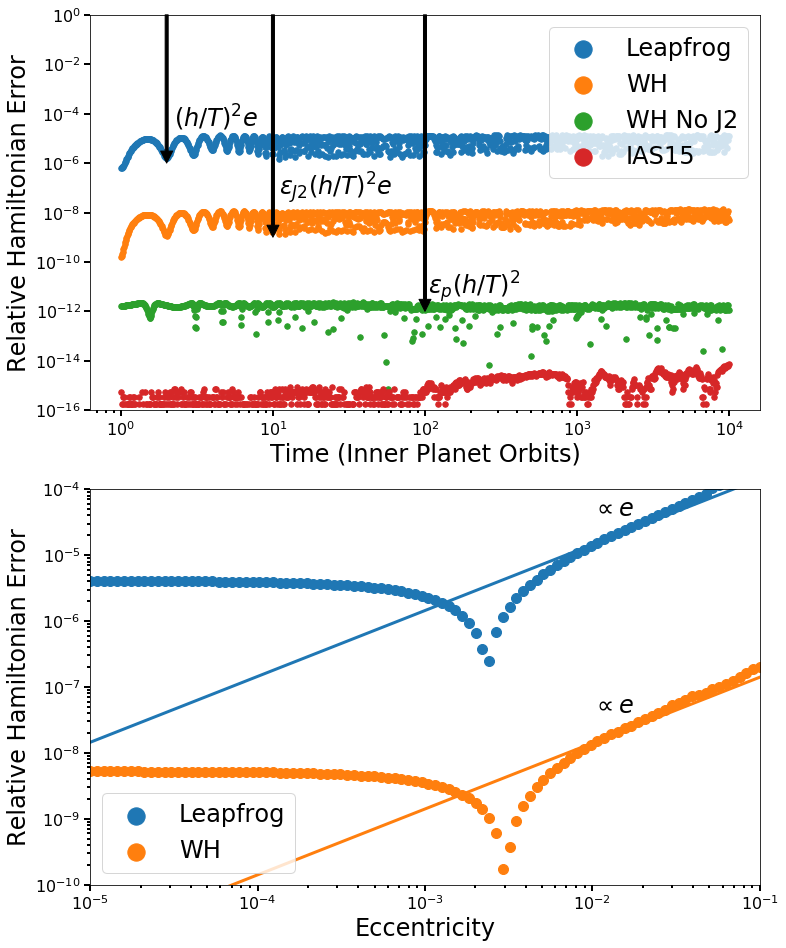

In [44]:
eps_p = 1.e-8
s = 30
fig, axarr = plt.subplots(nrows=2, figsize=(12,16))
ax = axarr[0]
ax.scatter(times, EsLF, s=s, label='Leapfrog')
ax.scatter(times, EsWH, s=s, label='WH')
ax.scatter(times, EsWHNoJ2, s=s, label='WH No J2')
ax.scatter(times, EsIAS15, s=s, label='IAS15')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1.e-16, 1.])

plt.rcParams["text.usetex"] = False
plt.locator_params(axis='y', numticks=5)

#ax.annotate(s='', xy=(4, dtfac**2), xytext=(4, 1), arrowprops=dict(width=3, facecolor='black'))
#ax.annotate(s='', xy=(2, e*dtfac**2), xytext=(2, 1), arrowprops=dict(width=3, facecolor='black'))
ax.annotate(s='', xy=(2, e*dtfac**2), xytext=(2, 1), arrowprops=dict(width=3, facecolor='black'))
ax.annotate(s='', xy=(10, e*eps_J2*dtfac**2), xytext=(10, 1), arrowprops=dict(width=3, facecolor='black'))

ax.annotate(s='', xy=(100, eps_p*dtfac**2), xytext=(100, 1), arrowprops=dict(width=3, facecolor='black'))
ax.text(2.25, 3.e-5, r'$(h/T)^2e$', fontsize=24)
ax.text(11, 5.e-8, r'$\epsilon_{J2}(h/T)^2e$', fontsize=24)
ax.text(105, 5.e-12, r'$\epsilon_{p}(h/T)^2$', fontsize=24)

ax.set_xlabel('Time (Inner Planet Orbits)', fontsize=24)
ax.set_ylabel('Relative Hamiltonian Error', fontsize=24)

lgnd = ax.legend(fontsize=24,loc='upper right', scatterpoints=1)
for handle in lgnd.legendHandles:
    handle.set_sizes([300])
    
ax1 = axarr[1]
mid = int(3*Nes/4)
ax1.scatter(es, ELF, label='Leapfrog')
ax1.scatter(es, EWH, label='WH')
ax1.plot(es, ELF[mid]*es/es[mid])
ax1.plot(es, EWH[mid]*es/es[mid])
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Eccentricity', fontsize=24)
ax1.set_ylabel('Relative Hamiltonian Error', fontsize=24)
ax1.set_ylim([1.e-10, 1.e-4])
ax1.set_xlim([1.e-5, 1.e-1])

ax1.text(1.e-2, 4.e-5, r'$\propto e$', fontsize=24)
ax1.text(1.e-2, 4.e-8, r'$\propto e$', fontsize=24)

lgnd = ax1.legend(fontsize=24,loc='lower left', scatterpoints=1)
for handle in lgnd.legendHandles:
    handle.set_sizes([300])

fig.savefig("fig1.pdf", bbox_inches='tight')

In [123]:
# Do IAS15split manually 

sim = makesim(eps_J2=None, e=e, dtfac=dtfac, integrator="ias15")
sim.ri_ias15.epsilon=0
rebx = reboundx.Extras(sim)
gh = rebx.load_force("gravitational_harmonics")
ps = sim.particles
ps[0].params['R_eq'] = ps[1].a
ps[0].params['J2'] = 2*eps_J2

integforce = rebx.load_operator("integrate_force")
integforce.params['force'] = gh
integforce.params['integrator'] = reboundx.integrators["rk4"]
rebx.add_operator(integforce, dt_fraction=0.5, timing="pre")
rebx.add_operator(integforce, dt_fraction=0.5, timing="post")

E0 = sim.calculate_energy() + rebx.gravitational_harmonics_hamiltonian()
EsIAS15Split = np.zeros(Nout)

for i, time in enumerate(times):
    sim.integrate(time)
    E = sim.calculate_energy() + rebx.gravitational_harmonics_hamiltonian()
    EsIAS15Split[i] = np.abs((E-E0)/E0)

CPU times: user 1.44 s, sys: 4.3 ms, total: 1.45 s
Wall time: 1.45 s


In [14]:
import pickle
pickle.dump((times, Es, EsJ2, EsJ2IAS15, EsJ2IAS15Split), open('fig1.pkl', 'w'))

In [184]:
try:
    plt.style.use('paper')
except:
    pass

In [7]:
epsilon_p = 1.e-8
epsilon_J2 = 1.e-4
dtOverT = 0.01
np.pi**2/6.*epsilon_p*dtOverT**2

1.6449340668482264e-12

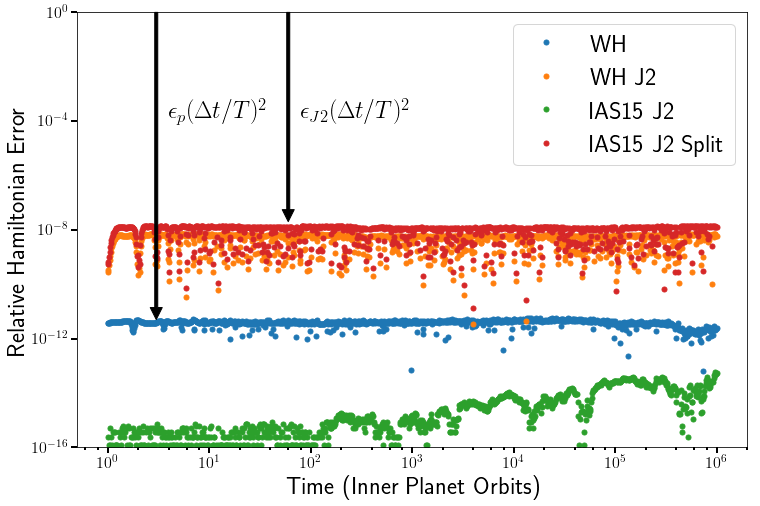

In [186]:
epsilon_p = 1.e-8
epsilon_J2 = 1.e-4
dtOverT = 0.01

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, Es, '.', label='WH')
ax.plot(times, EsJ2, '.', label='WH J2')
ax.plot(times, EsJ2IAS15, '.', label='IAS15 J2')
ax.plot(times, EsJ2IAS15Split, '.', label='IAS15 J2 Split')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1.e-16, 1.])

plt.rcParams["text.usetex"] =True
plt.locator_params(axis='y', numticks=5)
ax.annotate(s='', xy=(60, np.pi**2/6.*epsilon_p*dtOverT**2), xytext=(60, 1), arrowprops=dict(width=3, facecolor='black'))
ax.text(4, 1.e-4, r'$\epsilon_{p}(\Delta t/T)^2$', fontsize=24)

ax.annotate(s='', xy=(3, 5.e-12), xytext=(3, 1), arrowprops=dict(width=3, facecolor='black'))
ax.text(80, 1.e-4, r'$\epsilon_{J2}(\Delta t/T)^2$', fontsize=24)

ax.legend(fontsize=24)
ax.set_xlabel('Time (Inner Planet Orbits)', fontsize=24)
ax.set_ylabel('Relative Hamiltonian Error', fontsize=24)

fig.savefig("fig1.pdf", bbox_inches='tight')

In [126]:
simIAS = rebound.Simulation()
simIAS.add(m=1.)
simIAS.add(m=Mp, P=1., e=0.1)
simIAS.add(m=Mp, P=2.3, e=0.1)
simIAS.move_to_com()

E0 = sim.calculate_energy() + rebx.gravitational_harmonics_hamiltonian(sim)

rebxIAS = reboundx.Extras(simIAS)
rebxIAS.add("gravitational_harmonics")
ps = simIAS.particles
ps[0].params['J2'] = J2
ps[0].params['R_eq'] = ps[1].a

EsJ2 = np.zeros(Nout)
a = np.zeros(Nout)
times = np.logspace(0, 4, Nout)
a0 = sim.particles[1].a

for i, time in enumerate(times):
    sim.integrate(time)
    simIAS.integrate(time)
    E = sim.calculate_energy() + rebx.gravitational_harmonics_hamiltonian(sim)
    EsJ2[i] = np.abs((E-E0)/E0)
    phaseerr[i] = np.abs(sim.particles[1].f-simIAS.particles[1].f)/(2*np.pi)
    a[i] = np.abs((sim.particles[1].a-a0)/a0)

In [108]:
Mp = 1.e-6
Nout = 1000

sim = rebound.Simulation()
sim.add(m=1.)
sim.add(m=Mp, P=1., e=0.1)
sim.add(m=Mp, P=2.3, e=0.1)
sim.move_to_com()
sim.integrator="whfast"
sim.dt = 0.01*sim.particles[1].P

simIAS = rebound.Simulation()
simIAS.add(m=1.)
simIAS.add(m=Mp, P=1., e=0.1)
simIAS.add(m=Mp, P=2.3, e=0.1)
simIAS.move_to_com()

E0 = sim.calculate_energy()
Es = np.zeros(Nout)
phaseerr = np.zeros(Nout)
times = np.logspace(0, 4, Nout)

for i, time in enumerate(times):
    sim.integrate(time)
    simIAS.integrate(time)
    E = sim.calculate_energy()
    Es[i] = np.abs((E-E0)/E0)
    phaseerr[i] = np.abs(sim.particles[1].f-simIAS.particles[1].f)/(2*np.pi)

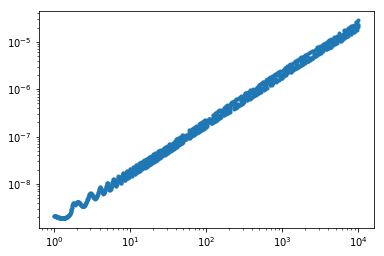

In [109]:
fig, ax = plt.subplots()
ax.plot(times, phaseerr, '.')
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_ylim([1.e-16, 1.e-8])

(1e-16, 1e-06)

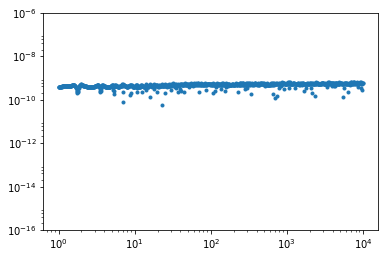

In [110]:
fig, ax = plt.subplots()
ax.plot(times, Es, '.')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1.e-16, 1.e-6])

In [126]:
Mp = 1.e-7
Nout = 1000
J2 = 1.e-3

sim = rebound.Simulation()
sim.add(m=1.)
sim.add(m=Mp, P=1., e=0.1)
sim.add(m=Mp, P=2.3, e=0.1)
sim.move_to_com()
sim.integrator="whfast"
sim.dt = 0.01*sim.particles[1].P

simIAS = rebound.Simulation()
simIAS.add(m=1.)
simIAS.add(m=Mp, P=1., e=0.1)
simIAS.add(m=Mp, P=2.3, e=0.1)
simIAS.move_to_com()

rebx = reboundx.Extras(sim)
rebx.add("gravitational_harmonics")
ps = sim.particles
ps[0].params['J2'] = J2
ps[0].params['R_eq'] = ps[1].a
E0 = sim.calculate_energy() + rebx.gravitational_harmonics_hamiltonian(sim)

rebxIAS = reboundx.Extras(simIAS)
rebxIAS.add("gravitational_harmonics")
ps = simIAS.particles
ps[0].params['J2'] = J2
ps[0].params['R_eq'] = ps[1].a

EsJ2 = np.zeros(Nout)
a = np.zeros(Nout)
times = np.logspace(0, 4, Nout)
a0 = sim.particles[1].a

for i, time in enumerate(times):
    sim.integrate(time)
    simIAS.integrate(time)
    E = sim.calculate_energy() + rebx.gravitational_harmonics_hamiltonian(sim)
    EsJ2[i] = np.abs((E-E0)/E0)
    phaseerr[i] = np.abs(sim.particles[1].f-simIAS.particles[1].f)/(2*np.pi)
    a[i] = np.abs((sim.particles[1].a-a0)/a0)

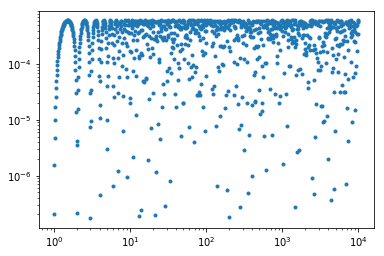

In [127]:
fig, ax = plt.subplots()
ax.plot(times, a, '.')
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_ylim([1.e-16, 1.e-8])

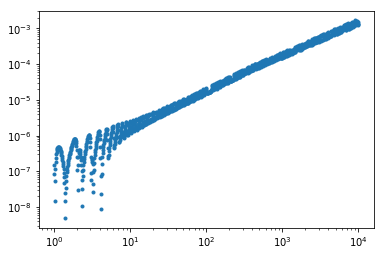

In [128]:
fig, ax = plt.subplots()
ax.plot(times, phaseerr, '.')
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_ylim([1.e-16, 1.e-8])

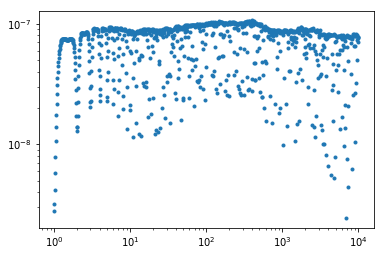

In [129]:
fig, ax = plt.subplots()
ax.plot(times, EsJ2, '.')
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_ylim([1.e-16, 1.e-8])

In [61]:
Mp = 1.e-7
Nout = 1000

sim = rebound.Simulation()
sim.add(m=1.)
sim.add(m=Mp, P=1.)
sim.add(m=Mp, P=2.3)
sim.move_to_com()
sim.integrator="whfast"
sim.dt = sim.particles[1].P/100

rebx = reboundx.Extras(sim)
rebx.add("gravitational_harmonics")
#gr = rebx.add('gr_potential')
#gr.params['c'] = 1.e2
ps = sim.particles
ps[0].params['J2'] = 1.e-1
ps[0].params['R_eq'] = ps[1].a
E0 = sim.calculate_energy() + rebx.gravitational_harmonics_hamiltonian(sim)
#E0 = sim.calculate_energy() + rebx.gr_potential_hamiltonian(sim, gr)


EsJ2 = np.zeros(Nout)
times = np.logspace(0, 4, Nout)

for i, time in enumerate(times):
    sim.integrate(time)
    E = sim.calculate_energy() + rebx.gravitational_harmonics_hamiltonian(sim)
    #E = sim.calculate_energy() + rebx.gr_potential_hamiltonian(sim, gr)

    EsJ2[i] = np.abs((E-E0)/E0)

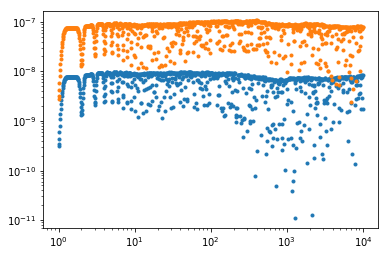

In [130]:
fig, ax = plt.subplots()
ax.plot(times, Es, '.')
ax.plot(times, EsJ2, '.')
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_ylim([1.e-16, 1.e-6])

In [24]:
Mp = 1.e-7
Nout = 1000

sim = rebound.Simulation()
sim.add(m=1.)
sim.add(m=Mp, P=1.)
sim.add(m=Mp, P=2.3)
sim.move_to_com()

rebx = reboundx.Extras(sim)
rebx.add("gravitational_harmonics")
ps = sim.particles
ps[0].params['J2'] = 1.e-4
ps[0].params['R_eq'] = 1.
E0 = sim.calculate_energy() + rebx.gravitational_harmonics_hamiltonian(sim)

EsJ2IAS15 = np.zeros(Nout)
times = np.logspace(0, 4, Nout)

for i, time in enumerate(times):
    sim.integrate(time)
    E = sim.calculate_energy() + rebx.gravitational_harmonics_hamiltonian(sim)
    EsJ2IAS15[i] = np.abs((E-E0)/E0)

(1e-16, 1e-06)

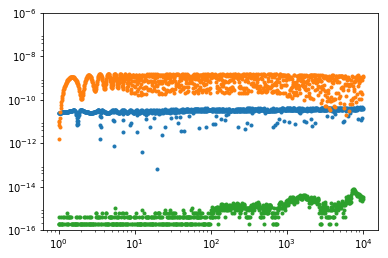

In [25]:
fig, ax = plt.subplots()
ax.plot(times, Es, '.')
ax.plot(times, EsJ2, '.')
ax.plot(times, EsJ2IAS15, '.')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1.e-16, 1.e-6])

In [14]:
ps[1].a

0.293687029488642